In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/researchPaperAssignment/models/inception

/content/drive/MyDrive/researchPaperAssignment/models/inception


In [3]:
!ls

best_inception_model2.h5    meta_train.tsv
best_inception_model3.h5    nnfl_crop
best_inception_model4.h5    nnfl_image
best_inception_model5.h5    __pycache__
best_inception_model6.h5    test
best_inception_model.h5     TestAccuracy_Inception.ipynb
history3.csv		    train
InceptionModel2.ipynb	    training_2
inceptionModel.py	    training_3
lfw.zip			    vecs2.tsv
local_Test_Inception.ipynb  vecs3.tsv
meta2.tsv		    vecs4.tsv
meta3.tsv		    vecs_train.tsv
meta4.tsv


In [4]:
!pip install -q pyyaml h5py

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import os

import sys
sys.path.append(os.path.join('..', '..'))

from global_params import *

# Setting hyper parameters for training and processing lfw dataset

In [6]:
batch_size = 200

In [7]:
# !unzip ../../data/train.zip
# !unzip ../../data/test.zip

In [8]:
train_path = os.path.join('train')

train_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
).flow_from_directory(
    train_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 6352 images belonging to 901 classes.


In [9]:
#Checkpoint
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_freq=5*31)

logger_callback = tf.keras.callbacks.CSVLogger("history3.csv", append=True)

In [11]:
# Hyperparameters
epochs = 80
learning_rate = 0.0003
# Using Reduce LR on Plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=13, verbose=1, mode='auto')

# Math works out so that one epoch equals one pass through the training data.
train_steps_per_epoch = train_batches.n // batch_size

#Building Inception Module with dimensionality reduction and Training it

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/iNy2U.png")

In [13]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [14]:
# define model input
input = keras.layers.Input(shape=input_shape)

conv1 = keras.layers.Conv2D(64, (7,7), activation='relu', strides=(2,2), padding='same', name='conv1')(input)
maxpool1 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1')(conv1)
norm1 = keras.layers.BatchNormalization(name='norm1')(maxpool1)

# add inception block 2
conv2_1 = keras.layers.Conv2D(64, (1,1), activation='relu', strides=(1,1), padding='same', name='conv2_1')(norm1)
conv2_3 = keras.layers.Conv2D(192, (3,3), activation='relu', strides=(1,1), padding='same', name='conv2_3')(conv2_1)
norm2 = keras.layers.BatchNormalization(name='norm2')(conv2_3)
maxpool2 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool2')(norm2)

# add inception block 3a
inception3a = inception_module(maxpool2, 64, 96, 128, 16, 32, 32)

# add inception block 3b
inception3b = inception_module(inception3a, 64, 96, 128, 32, 64, 64)

# add inception block 3c
conv3_3c = keras.layers.Conv2D(128, (1,1), padding='same', activation='relu')(inception3b)
conv3_3c = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(conv3_3c)
# 5x5 conv
conv5_3c = keras.layers.Conv2D(32, (1,1), padding='same', activation='relu')(inception3b)
conv5_3c = keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', activation='relu')(conv5_3c)
# 3x3 max pooling
pool_3c = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(inception3b)
# concatenate filters, assumes filters/channels last
layer_out_3c = keras.layers.concatenate([conv3_3c, conv5_3c, pool_3c], axis=-1)

# add inception block 4a
inception4a = inception_module(layer_out_3c, 256, 96, 192, 32, 64, 128)

# add inception block 4b
inception4b = inception_module(inception4a, 224, 112, 224, 32, 64, 128)

# add inception block 4c
inception4c = inception_module(inception4b, 192, 128, 256, 32, 64, 128)

# add inception block 4d
inception4d = inception_module(inception4c, 160, 144, 288, 32, 64, 128)

# add inception block 4e
conv3_4e = keras.layers.Conv2D(160, (1,1), padding='same', activation='relu')(inception4d)
conv3_4e = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(conv3_4e)
# 5x5 conv
conv5_4e = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(inception4d)
conv5_4e = keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same', activation='relu')(conv5_4e)
# 3x3 max pooling
pool_4e = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(inception4d)
# concatenate filters, assumes filters/channels last
layer_out_4e = keras.layers.concatenate([conv3_4e, conv5_4e, pool_4e], axis=-1)

# add inception block 5a
inception5a = inception_module(layer_out_4e, 384, 192, 384, 48, 128, 128)

# add inception block 5b
inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)

# global average pooling layer
avgpool = keras.layers.GlobalAveragePooling2D()(inception5b)

# Flatten
# flat = keras.layers.Flatten(name='flatten')(avgpool)
drop = keras.layers.Dropout(0.2)(avgpool)
# dense fc layer
fc = keras.layers.Dense(128, name='fc1')(drop)
# L2 norm
l2norm = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2')(fc)

# create model
model = keras.Model(inputs=input, outputs=l2norm, name='NN2')

In [16]:
model.summary()

Model: "NN2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, 24, 24, 64)   256         pool1[0][0]                      
________________________________________________________________________________________________

In [ ]:
model.save_weights(checkpoint_path.format(epoch=0))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2),
)

In [ ]:
model.load_weights("best_inception_model6.h5")

In [ ]:
# %%script echo "Comment line with %%script echo to run this cell."

history = model.fit(
    train_batches,
    epochs=epochs,
    steps_per_epoch=train_steps_per_epoch,
    callbacks=[cp_callback, logger_callback, reduce_lr]
)

Epoch 1/80
31/31 [==============================] - 1183s 38s/step - loss: 0.0326
Epoch 2/80
31/31 [==============================] - 233s 8s/step - loss: 0.0327
Epoch 3/80
31/31 [==============================] - 232s 7s/step - loss: 0.0321
Epoch 4/80
31/31 [==============================] - 232s 7s/step - loss: 0.0331
Epoch 5/80
30/31 [============================>.] - ETA: 7s - loss: 0.0329 
Epoch 00005: saving model to training_3/cp-0005.ckpt
31/31 [==============================] - 236s 8s/step - loss: 0.0339
Epoch 6/80
31/31 [==============================] - 233s 8s/step - loss: 0.0321
Epoch 7/80
31/31 [==============================] - 238s 8s/step - loss: 0.0339
Epoch 8/80
31/31 [==============================] - 233s 8s/step - loss: 0.0326
Epoch 9/80
31/31 [==============================] - 233s 8s/step - loss: 0.0316
Epoch 10/80
30/31 [============================>.] - ETA: 7s - loss: 0.0344 
Epoch 00010: saving model to training_3/cp-0010.ckpt
31/31 [=======================

In [ ]:
#get the latest checkpoint file
latest = tf.train.latest_checkpoint(checkpoint_dir)

ERROR:tensorflow:Couldn't match files for checkpoint training_2/cp-0260.ckpt


In [ ]:
print(checkpoint_dir)

training_2


In [ ]:
latest

'training_2/cp-0260.ckpt'

In [ ]:
# Run model again
# Load the previously saved weights
model.load_weights('training_3/cp-0075.ckpt')

In [ ]:
# Evaluate the network
results = model.predict(train_batches)

In [ ]:
# Save test embeddings for visualization in projector
np.savetxt("vecs_zf2.tsv", results, delimiter='\t')

x=np.concatenate([train_batches.next()[0] for i in range(train_batches.__len__())])
y=np.concatenate([train_batches.next()[1] for i in range(train_batches.__len__())])
print(x.shape)
print(y.shape)
y = y.astype(int)

import io

out_m = io.open('meta2_zf.tsv', 'w', encoding='utf-8')
for img, label in zip(x,y):
    [out_m.write(str(label) + "\n")]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass


(6352, 96, 96, 1)
(6352,)


In [ ]:
# %%script echo "Comment line with %%script echo to run this cell."
model.save('best_inception_model6.h5')

In [ ]:
import pandas as pd
df = pd.read_csv('history3.csv')

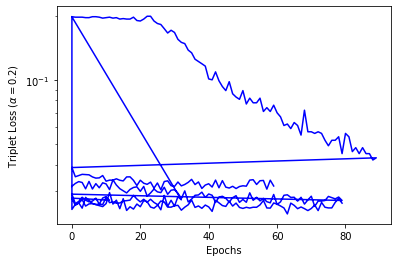

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel(r'Triplet Loss $(\alpha=0.2)$')
plt.yscale('log')
plt.plot(df['epoch'], df['loss'], color='b')

In [ ]:
exit()